# Forecasting Influenza Flu cases in Australia with XGBoost and SARIMAX 

## Shiivong Kapil Birla

Influenza, commonly known as "the flu", is an infectious disease caused by an influenza virus. Symptoms can be mild to severe. The most common symptoms include: high fever, runny nose, sore throat, muscle and joint pain, headache, coughing, and feeling tired. These symptoms typically begin two days after exposure to the virus and most last less than a week. The cough, however, may last for more than two weeks. In children, there may be diarrhea and vomiting, but these are not common in adults. Diarrhea and vomiting occur more commonly in gastroenteritis, which is an unrelated disease and sometimes inaccurately referred to as "stomach flu" or the "24-hour flu". Complications of influenza may include viral pneumonia, secondary bacterial pneumonia, sinus infections, and worsening of previous health problems such as asthma or heart failure.

Three of the four types of influenza viruses affect humans: Type A, Type B, and Type C. Type D has not been known to infect humans, but is believed to have the potential to do so. Usually, the virus is spread through the air from coughs or sneezes. This is believed to occur mostly over relatively short distances. It can also be spread by touching surfaces contaminated by the virus and then touching the eyes, nose, or mouth. A person may be infectious to others both before and during the time they are showing symptoms. The infection may be confirmed by testing the throat, sputum, or nose for the virus. A number of rapid tests are available; however, people may still have the infection even if the results are negative. A type of polymerase chain reaction that detects the virus's RNA is more accurate. (source - https://en.wikipedia.org/wiki/Influenza)

Before we get our hands dirty with the data, let's load some of the most common packages which we know will come in extremely handy in this task.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import pandasql as ps
import datetime
from pylab import rcParams

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel('Influenza (laboratory confirmed) Public datset 2008 to 2017.xlsx')

In [3]:
data.head()

,Influenza (laboratory confirmed) NNDSS notifications in Australia 2008-2017\n *NNDSS data current as at 31/07/2018,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Week Ending (Friday),State,Age group,Sex,Indigenous status,Type/Subtype
1,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
2,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
3,2018-01-05 00:00:00,NSW,00-04,Male,not available,A(unsubtyped)
4,2018-01-05 00:00:00,NSW,20-24,Male,not available,B


Immediately, we can see that the data is not in the best format as well as the headers are misplaced and make little sense. We shall rename the columns and transform the date in the right format.

In [4]:
data.columns = ['Date', 'State', 'Age_Group', 'Sex', 'Indigenous_Status', 'Type_Subtype']
data = data[1:]

In [5]:
print(type(data['Date'][1]))

<class 'datetime.datetime'>


The date column is of the datetime type, which is what we want, if we are to do time-series analysis on this dataset. Let's take a peak into our new, transformed dataset.

In [6]:
data.head(n = 10)

,Date,State,Age_Group,Sex,Indigenous_Status,Type_Subtype
1,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
2,2018-01-05 00:00:00,NSW,00-04,Female,not available,B
3,2018-01-05 00:00:00,NSW,00-04,Male,not available,A(unsubtyped)
4,2018-01-05 00:00:00,NSW,20-24,Male,not available,B
5,2018-01-05 00:00:00,NSW,25-29,Male,not available,A(unsubtyped)
6,2018-01-05 00:00:00,NSW,30-34,Female,not available,A(unsubtyped)
7,2018-01-05 00:00:00,NSW,40-44,Female,not available,B
8,2018-01-05 00:00:00,NSW,45-49,Female,not available,A(unsubtyped)
9,2018-01-05 00:00:00,NSW,60-64,Female,not available,B
10,2018-01-05 00:00:00,NSW,75-79,Female,not available,B


Data looks neat now! Let's dive straight into finding out more about what we have here.

## What can I tell about this dataset?

# EDA

In statistics, exploratory data analysis is an approach to analyzing data sets to summarize their main characteristics, often with visual methods. A statistical model can be used or not, but primarily EDA is for seeing what the data can tell us beyond the formal modeling or hypothesis testing task. Exploratory data analysis was promoted by John Tukey to encourage statisticians to explore the data, and possibly formulate hypotheses that could lead to new data collection and experiments. EDA is different from initial data analysis (IDA), which focuses more narrowly on checking assumptions required for model fitting and hypothesis testing, and handling missing values and making transformations of variables as needed. EDA encompasses IDA. (soruce - https://en.wikipedia.org/wiki/Exploratory_data_analysis)

In [7]:
data.describe()

,Date,State,Age_Group,Sex,Indigenous_Status,Type_Subtype
count,681254,681254,681254,681254,681254,681254
unique,523,7,19,4,4,8
top,2017-08-18 00:00:00,NSW,00-04,Female,not available,A(unsubtyped)
freq,24004,229134,75022,366829,447393,353092


The dataset is huge, looking at the sheer amount of rows which is close to 700,000. All the attribues are categorical,  with the date attribute being the potential index attribute. 

# Feature Engineering

Feature engineering is the process of using domain knowledge to extract features from raw data via data mining techniques. These features can be used to improve the performance of machine learning algorithms. Feature engineering can be considered as applied machine learning itself. (source - https://en.wikipedia.org/wiki/Feature_engineering)

We have a date, and already I'm thinking about extracting the relevant months, years and days from it as part of our `feature engineering` campaign. This will come in very handy when we are doing Data Visualization.

In [8]:
sns.set(style = 'ticks', color_codes = True)

I've made use of the seamless `SQLLite` integration with `pandas` by using the `pandasql` library. We will be using SQL to transform our data, depending on the business need. 

In [9]:
data['Month'] = ps.sqldf('select strftime("%m", Date) as Month from data')

In [10]:
data['Year'] = ps.sqldf('select strftime("%Y", Date) as Year from data')

In [11]:
data.head()

,Date,State,Age_Group,Sex,Indigenous_Status,Type_Subtype,Month,Year
1,2018-01-05 00:00:00,NSW,00-04,Female,not available,B,01,2018
2,2018-01-05 00:00:00,NSW,00-04,Female,not available,B,01,2018
3,2018-01-05 00:00:00,NSW,00-04,Male,not available,A(unsubtyped),01,2018
4,2018-01-05 00:00:00,NSW,20-24,Male,not available,B,01,2018
5,2018-01-05 00:00:00,NSW,25-29,Male,not available,A(unsubtyped),01,2018


In [12]:
data.tail()

,Date,State,Age_Group,Sex,Indigenous_Status,Type_Subtype,Month,Year
681250,2008-01-04 00:00:00,WA,80-84,Male,non-Indigenous,A(unsubtyped),01,2008
681251,2008-01-04 00:00:00,NT,00-04,Male,Indigenous,Untyped,01,2008
681252,2008-01-04 00:00:00,NT,50-54,Female,Indigenous,A(unsubtyped),01,2008
681253,2008-01-04 00:00:00,Qld,15-19,Female,non-Indigenous,A(unsubtyped),01,2008
681254,2008-01-04 00:00:00,WA,80-84,Male,non-Indigenous,A(unsubtyped),NaN,NaN


Oh no! Looks like we may have forced some missing values in our datset with the transform operation we performed above. But how many missing values do we have in our dataset anyway? Time to find out.

In [13]:
print(data.isnull().sum())

Date                 0
State                0
Age_Group            0
Sex                  0
Indigenous_Status    0
Type_Subtype         0
Month                1
Year                 1
dtype: int64


Phew! There's just one value that's missing, which isn't much of a deal. We could just discard it and move forward with our analysis. 

In [14]:
data = data.dropna()

In [15]:
data.tail()

,Date,State,Age_Group,Sex,Indigenous_Status,Type_Subtype,Month,Year
681249,2008-01-04 00:00:00,WA,60-64,Male,non-Indigenous,B,01,2008
681250,2008-01-04 00:00:00,WA,80-84,Male,non-Indigenous,A(unsubtyped),01,2008
681251,2008-01-04 00:00:00,NT,00-04,Male,Indigenous,Untyped,01,2008
681252,2008-01-04 00:00:00,NT,50-54,Female,Indigenous,A(unsubtyped),01,2008
681253,2008-01-04 00:00:00,Qld,15-19,Female,non-Indigenous,A(unsubtyped),01,2008


The missing value is now gone, as it was just one row, it won't impact our analysis or visualization in a significant way. Now, moving on to exploring some of the other attribues to see see their distribution and spread and to see if we can transform them in ways to fit our need.

In [16]:
data['Age_Group'].unique()

array(['00-04', '20-24', '25-29', '30-34', '40-44', '45-49', '60-64',
       '75-79', '80-84', '65-69', '05-09', '35-39', '50-54', '85+',
       '10-14', '55-59', '70-74', '15-19', 'Unknown'], dtype=object)

Those are a lot of values, and at this point it may seem innocuous, it'll be detrimental to our analysis and visualization. Thus, we need to limit the values by changing them and givig them a different order.

In [17]:
data['Age_Group'][data['Age_Group'] == '00-04'] = 'Children'
data['Age_Group'][data['Age_Group'] == '05-09'] = 'Children'
data['Age_Group'][data['Age_Group'] == '10-14'] = 'Children'
data['Age_Group'][data['Age_Group'] == '15-19'] = 'Children'

data['Age_Group'][data['Age_Group'] == '20-24'] = 'Adults'
data['Age_Group'][data['Age_Group'] == '25-29'] = 'Adults'
data['Age_Group'][data['Age_Group'] == '30-34'] = 'Adults'
data['Age_Group'][data['Age_Group'] == '35-39'] = 'Adults'

data['Age_Group'][data['Age_Group'] == '40-44'] = 'Mid-Aged Adults'
data['Age_Group'][data['Age_Group'] == '45-49'] = 'Mid-Aged Adults'
data['Age_Group'][data['Age_Group'] == '50-54'] = 'Mid-Aged Adults'
data['Age_Group'][data['Age_Group'] == '55-59'] = 'Mid-Aged Adults'

data['Age_Group'][data['Age_Group'] == '60-64'] = 'Senior Citizens'
data['Age_Group'][data['Age_Group'] == '65-69'] = 'Senior Citizens'
data['Age_Group'][data['Age_Group'] == '70-74'] = 'Senior Citizens'
data['Age_Group'][data['Age_Group'] == '75-79'] = 'Senior Citizens'
data['Age_Group'][data['Age_Group'] == '80-84'] = 'Senior Citizens'
data['Age_Group'][data['Age_Group'] == '85+'] = 'Senior Citizens'

In [18]:
data['Age_Group'].unique()

array(['Children', 'Adults', 'Mid-Aged Adults', 'Senior Citizens',
       'Unknown'], dtype=object)

Age group was the only column with so many levels, we'll leave other columns just the way they are.

# Data Visualization

Data visualization is the graphic representation of data. It involves producing images that communicate relationships among the represented data to viewers of the images. This communication is achieved through the use of a systematic mapping between graphic marks and data values in the creation of the visualization. This mapping establishes how data values will be represented visually, determining how and to what extent a property of a graphic mark, such as size or color, will change to reflect changes in the value of a datum.

To communicate information clearly and efficiently, data visualization uses statistical graphics, plots, information graphics and other tools. Numerical data may be encoded using dots, lines, or bars, to visually communicate a quantitative message. Effective visualization helps users analyze and reason about data and evidence. It makes complex data more accessible, understandable and usable. Users may have particular analytical tasks, such as making comparisons or understanding causality, and the design principle of the graphic (i.e., showing comparisons or showing causality) follows the task. Tables are generally used where users will look up a specific measurement, while charts of various types are used to show patterns or relationships in the data for one or more variables.

Data visualization is both an art and a science. It is viewed as a branch of descriptive statistics by some, but also as a grounded theory development tool by others. Increased amounts of data created by Internet activity and an expanding number of sensors in the environment are referred to as "big data" or Internet of things. Processing, analyzing and communicating this data present ethical and analytical challenges for data visualization. The field of data science and practitioners called data scientists help address this challenge. (source - https://en.wikipedia.org/wiki/Data_visualization)

### Cases as a function of Month, Sex and Year

It's always good to make subset of the data which you want to visualize or analyse. Using the `pandasql` library, we will transform our subsetted dataset. Here, our aim is to find out how the number of cases change with time and gender.

In [19]:
data_gender = data[['Month', 'Sex']]

In [20]:
data_gender = ps.sqldf('select Month, Sex, count(Sex) as [Case Count] from data_gender group by \
Month, Sex order by Month')

In [21]:
data_gender.head()

,Month,Sex,Case Count
0,01,Female,4581
1,01,Male,4187
2,01,Unknown,5
3,02,Female,4802
4,02,Male,4298


Looks good, but wouldn't it be better if we just renamed the months? Like January instead of 01?

In [22]:
data_gender['Month'][data_gender['Month'] == '01'] = 'January'
data_gender['Month'][data_gender['Month'] == '02'] = 'February'
data_gender['Month'][data_gender['Month'] == '03'] = 'March'
data_gender['Month'][data_gender['Month'] == '04'] = 'April'
data_gender['Month'][data_gender['Month'] == '05'] = 'May'
data_gender['Month'][data_gender['Month'] == '06'] = 'June'
data_gender['Month'][data_gender['Month'] == '07'] = 'July'
data_gender['Month'][data_gender['Month'] == '08'] = 'August'
data_gender['Month'][data_gender['Month'] == '09'] = 'September'
data_gender['Month'][data_gender['Month'] == '10'] = 'October'
data_gender['Month'][data_gender['Month'] == '11'] = 'November'
data_gender['Month'][data_gender['Month'] == '12'] = 'December'

In [23]:
data_gender.head()

,Month,Sex,Case Count
0,January,Female,4581
1,January,Male,4187
2,January,Unknown,5
3,February,Female,4802
4,February,Male,4298


How are the number of cases distributed over the 12 months? Do some months have higher cases than other months? Do the number of flu cases skyrocket during certain months?

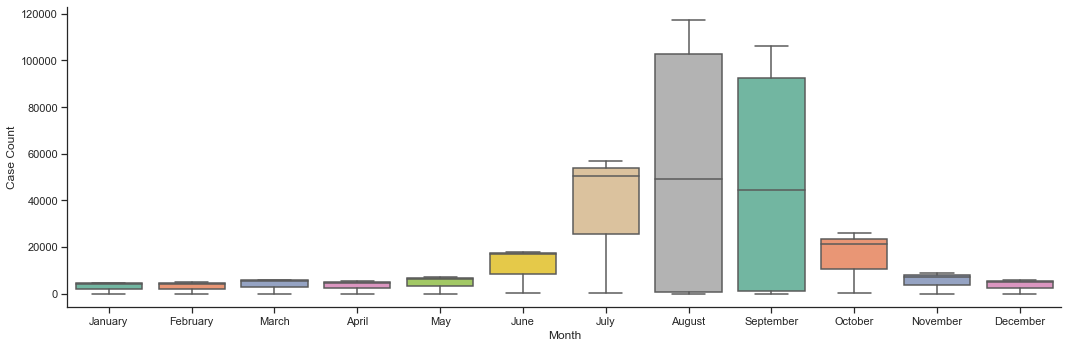

In [24]:
sns.catplot(x = 'Month', y = 'Case Count', kind = 'box', data = data_gender, height = 5, aspect = 3, palette = 'Set2')

**Insight** : Flu cases skyrocket from June to October. This is consisent with the notion that flu cases **increase in the winter, rainy season and die out during the summer season**.  

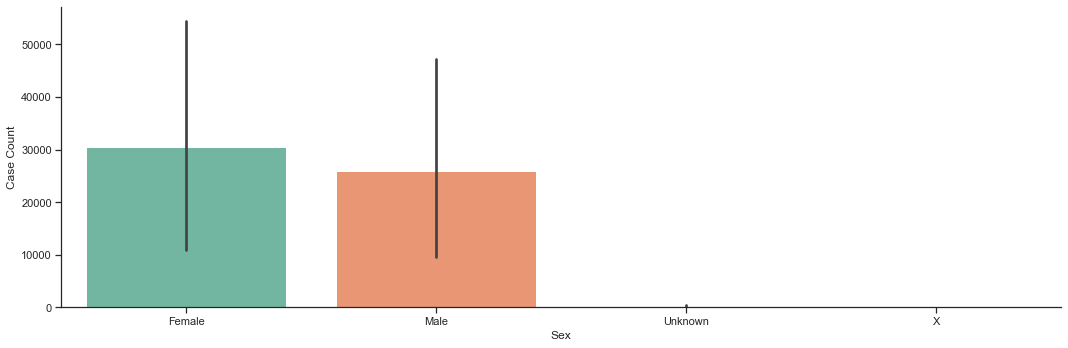

In [25]:
sns.catplot(x = 'Sex', y = 'Case Count', kind = 'bar', data = data_gender, height = 5, aspect = 3, palette = 'Set2')

**Insight** : From the visualization, it looks like **on average, more females catch the flu every year than males**.

Now, let's see what is the trend for number of flu cases over the years. we'll again subset our data and take only the columns that are required for the analysis and visualization.

In [26]:
data_gender = data[['Year', 'Sex']]

In [27]:
data_gender = ps.sqldf('select Year, Sex, count(Sex) as [Case Count] from data_gender group by \
Year, Sex order by Year')

In [28]:
data_gender.head()

,Year,Sex,Case Count
0,2008,Female,4634
1,2008,Male,4264
2,2008,Unknown,8
3,2009,Female,29172
4,2009,Male,28248


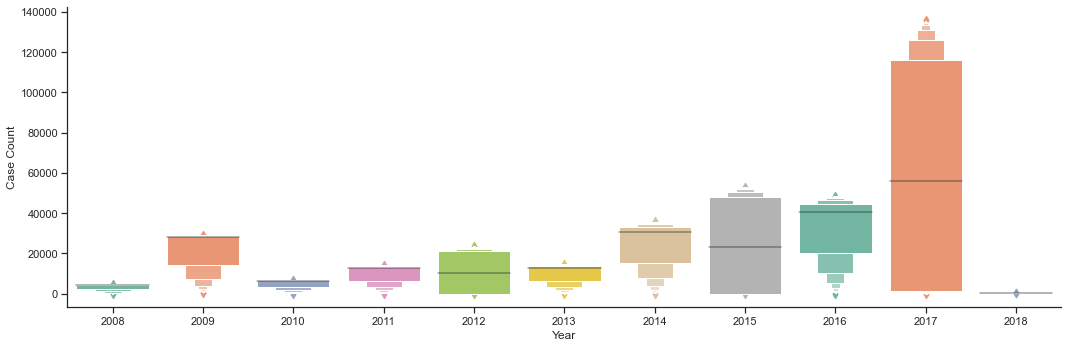

In [29]:
sns.catplot(x = 'Year', y = 'Case Count', kind = 'boxen', data = data_gender, height = 5, aspect = 3, palette = 'Set2')

**Insight** : We can clearly see an **increasing trend of flu cases**.

### Cases as a function of State

Are all Australian states having the same distribution of cases, as a statistician, you might expect that, but let's plot and find out for sure. Similarly, we will subset our data to have only the dates and states.

In [30]:
data_state = data['State']

In [31]:
data_state = ps.sqldf('select State, count(State) as [Case Count] from data_state group by State')

In [32]:
data_state.head()

,State,Case Count
0,NSW,229134
1,NT,7839
2,Qld,183288
3,SA,94399
4,Tas,10226


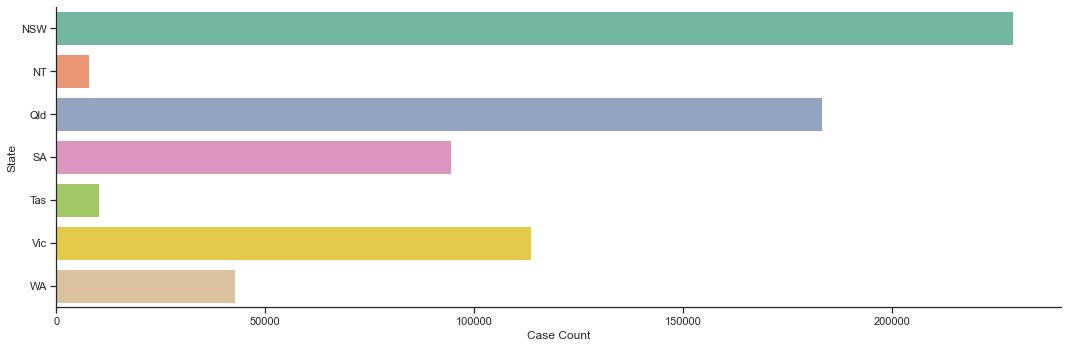

In [33]:
sns.catplot(x = 'Case Count', y = 'State', kind = 'bar', data = data_state, height = 5, \
            aspect = 3, palette = 'Set2')

**Insight** : **NSW has had the most number of cases** as compared to other states. **NT** and **Tasmania** have had the lowest number of cases.

### Which State and Age Group has the most flu cases over the years and did the trend change?

We now know that **NSW** has had the highest number of flu cases historically, but how does the **age group** impact the trend? By subsetting the data agai, we will analyze and visualize the said statement to see if there is any visual cue for us to answer the question.

In [34]:
data_flu_trend = data[['Year', 'State', 'Age_Group']]

In [35]:
data_flu_trend = ps.sqldf('select Year, State, Age_Group, count(Age_Group) as [Case Count] from data_flu_trend group by \
Year, State, Age_Group order by Year')

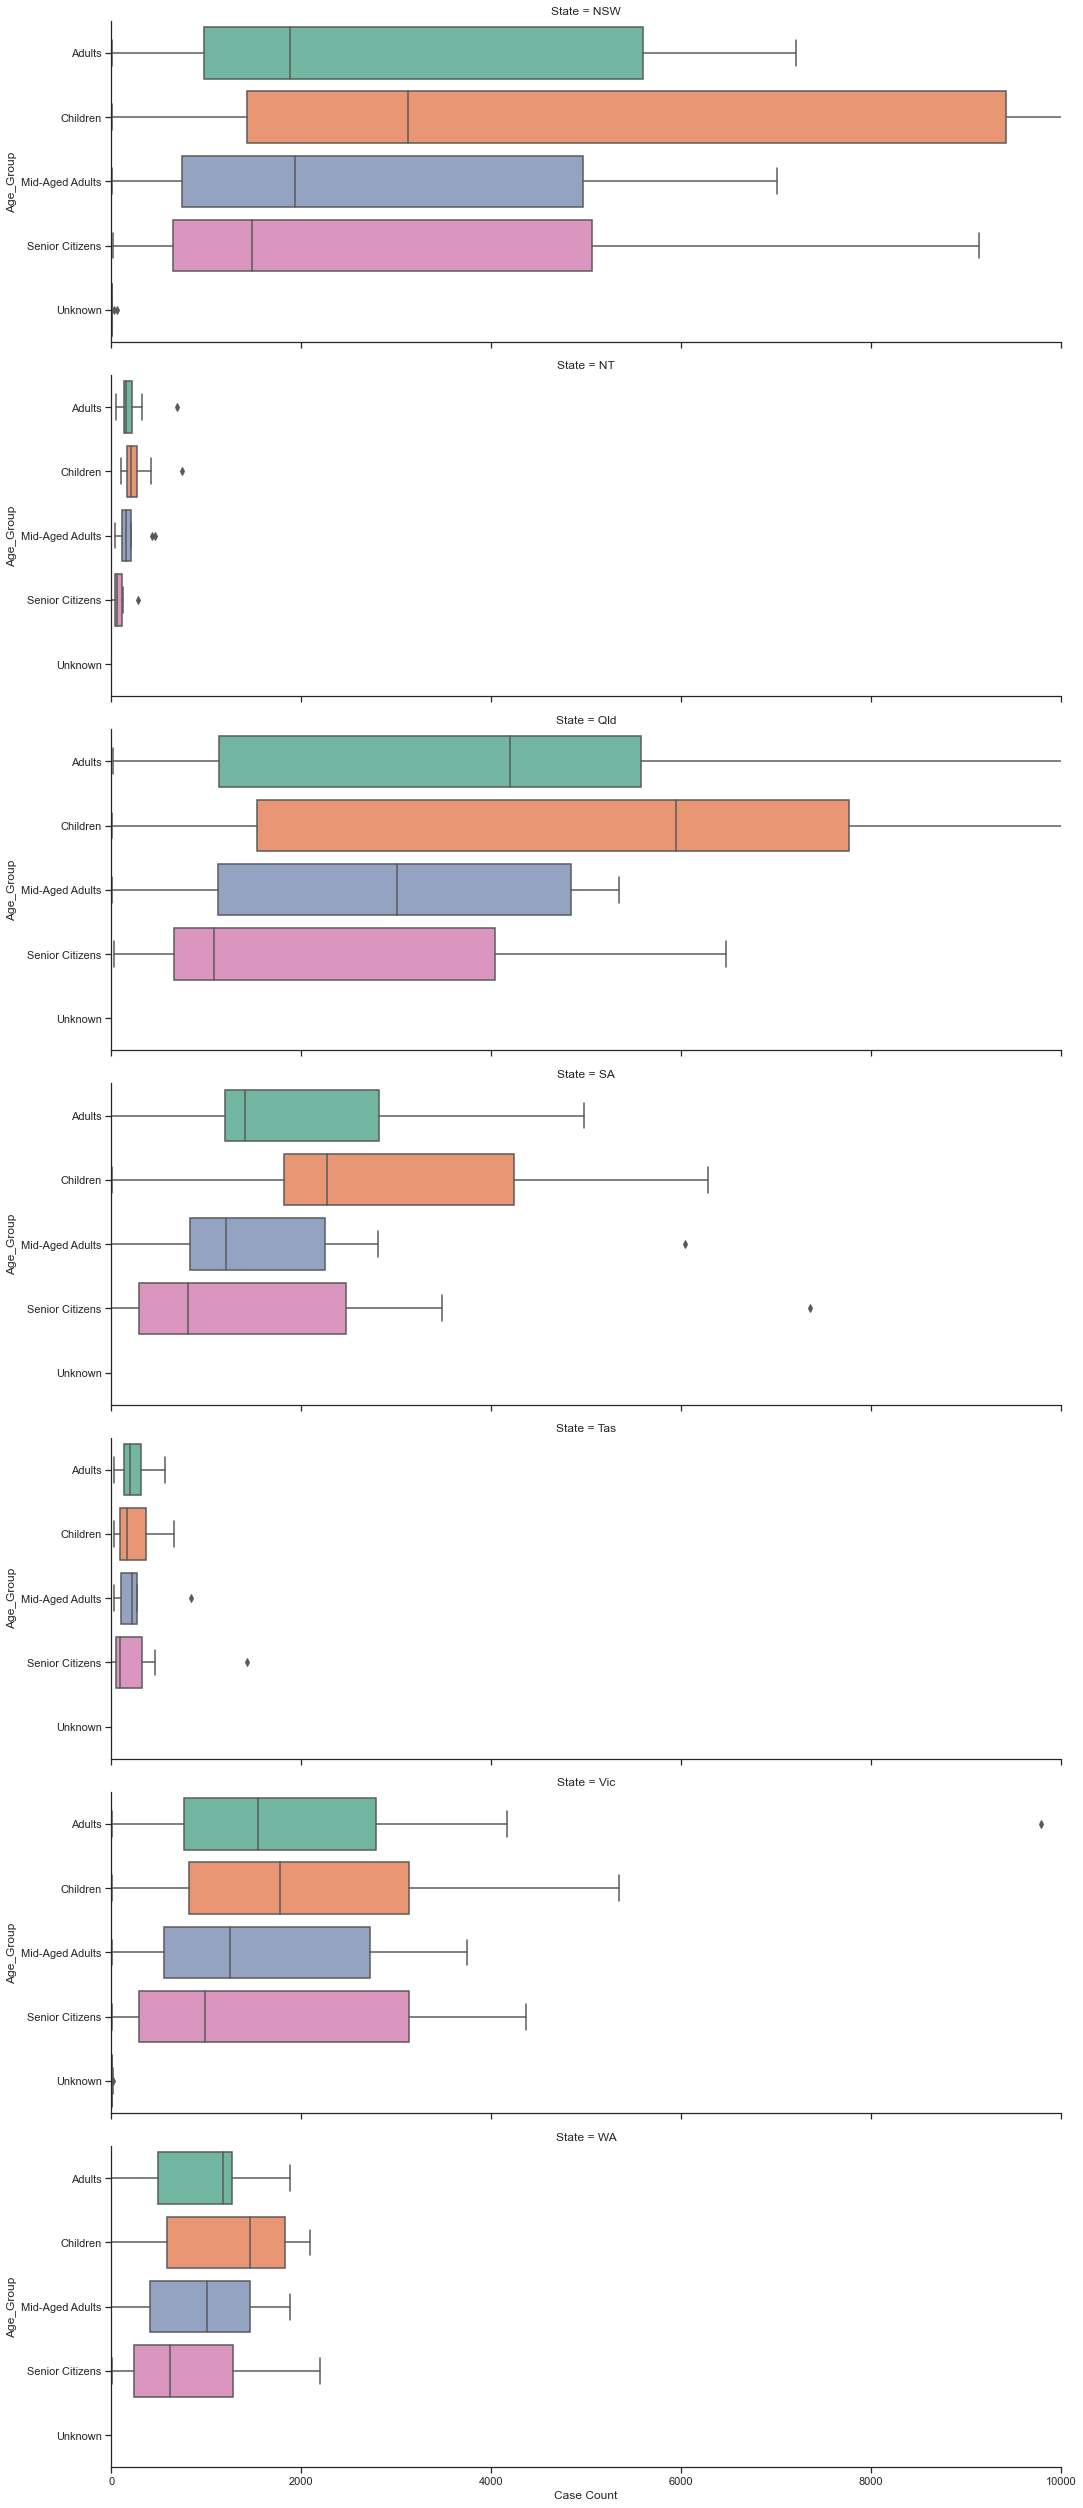

In [36]:
sns_age = sns.catplot(x = 'Case Count', y = 'Age_Group', row = 'State', data = data_flu_trend, kind = 'box', height = 5, \
                      aspect = 3, palette = 'Set2')
sns_age.set(xlim = (0, 10000))
plt.show()

**Insight** : The general trend is that **Children (0-18 years) catch the flu more than any other age group.** However, **Victoria** is an exception where more **Senior Citizens (60+)** catch the flu than **Children**.

Moving on, how is the same trend over the years?

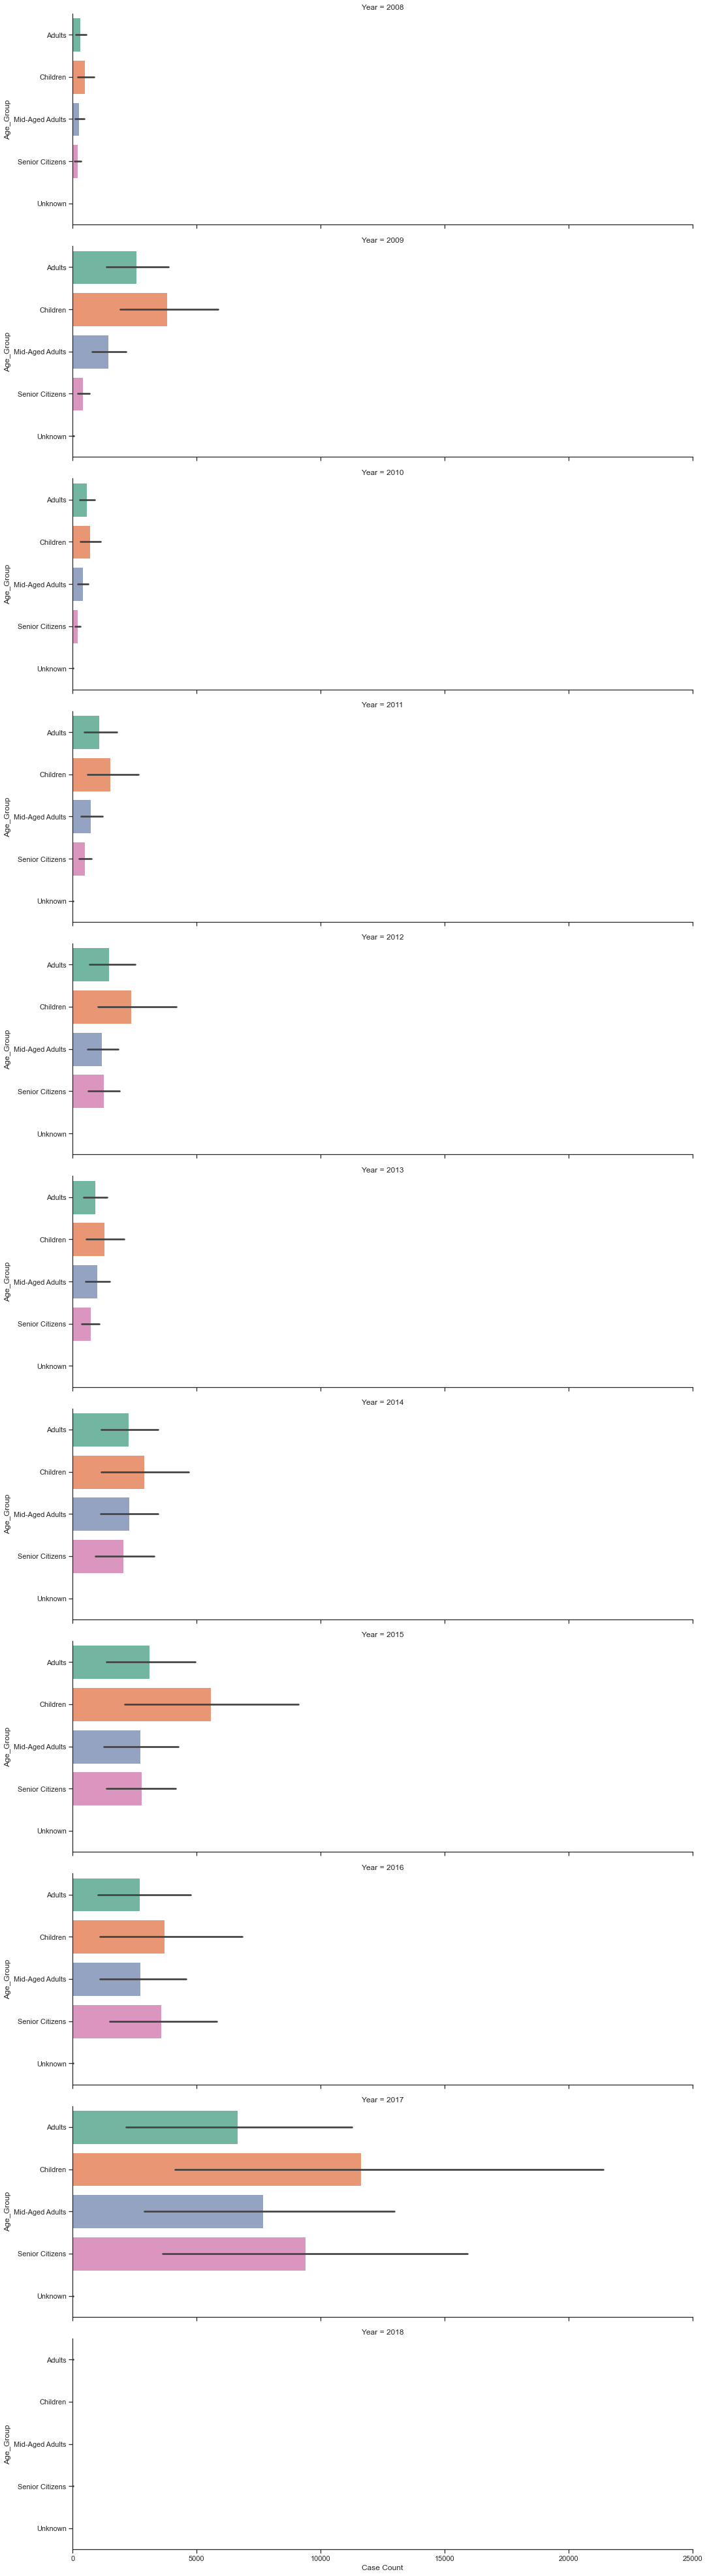

In [37]:
sns_age = sns.catplot(x = 'Case Count', y = 'Age_Group', row = 'Year', data = data_flu_trend, kind = 'bar', height = 5, \
                      aspect = 3, palette = 'Set2')
sns_age.set(xlim = (0, 25000))
plt.show()

**Insight** : The overall proportion of cases belonging to **Children, Adults, Mid-Aged Adults and Senior Citizens** has more or less been consistent through the years. 

### Which Flu Type or Subtype most serious in Australia?

By now we know that hunred of thousands of people catch the flu every year in Australia, but what type (or subtype) of flu has been the most infectious over the years?

In [38]:
data_type = data[['Year', 'Type_Subtype']]

In [39]:
data_type = ps.sqldf('select Year, Type_Subtype, count(Type_Subtype) as [Case Count] from data_type \
group by Year, Type_Subtype order by Year')

In [40]:
data_type.head()

,Year,Type_Subtype,Case Count
0,2008,A and B,6
1,2008,A(H1N1),188
2,2008,A(H3N2),364
3,2008,A(unsubtyped),3352
4,2008,B,4899


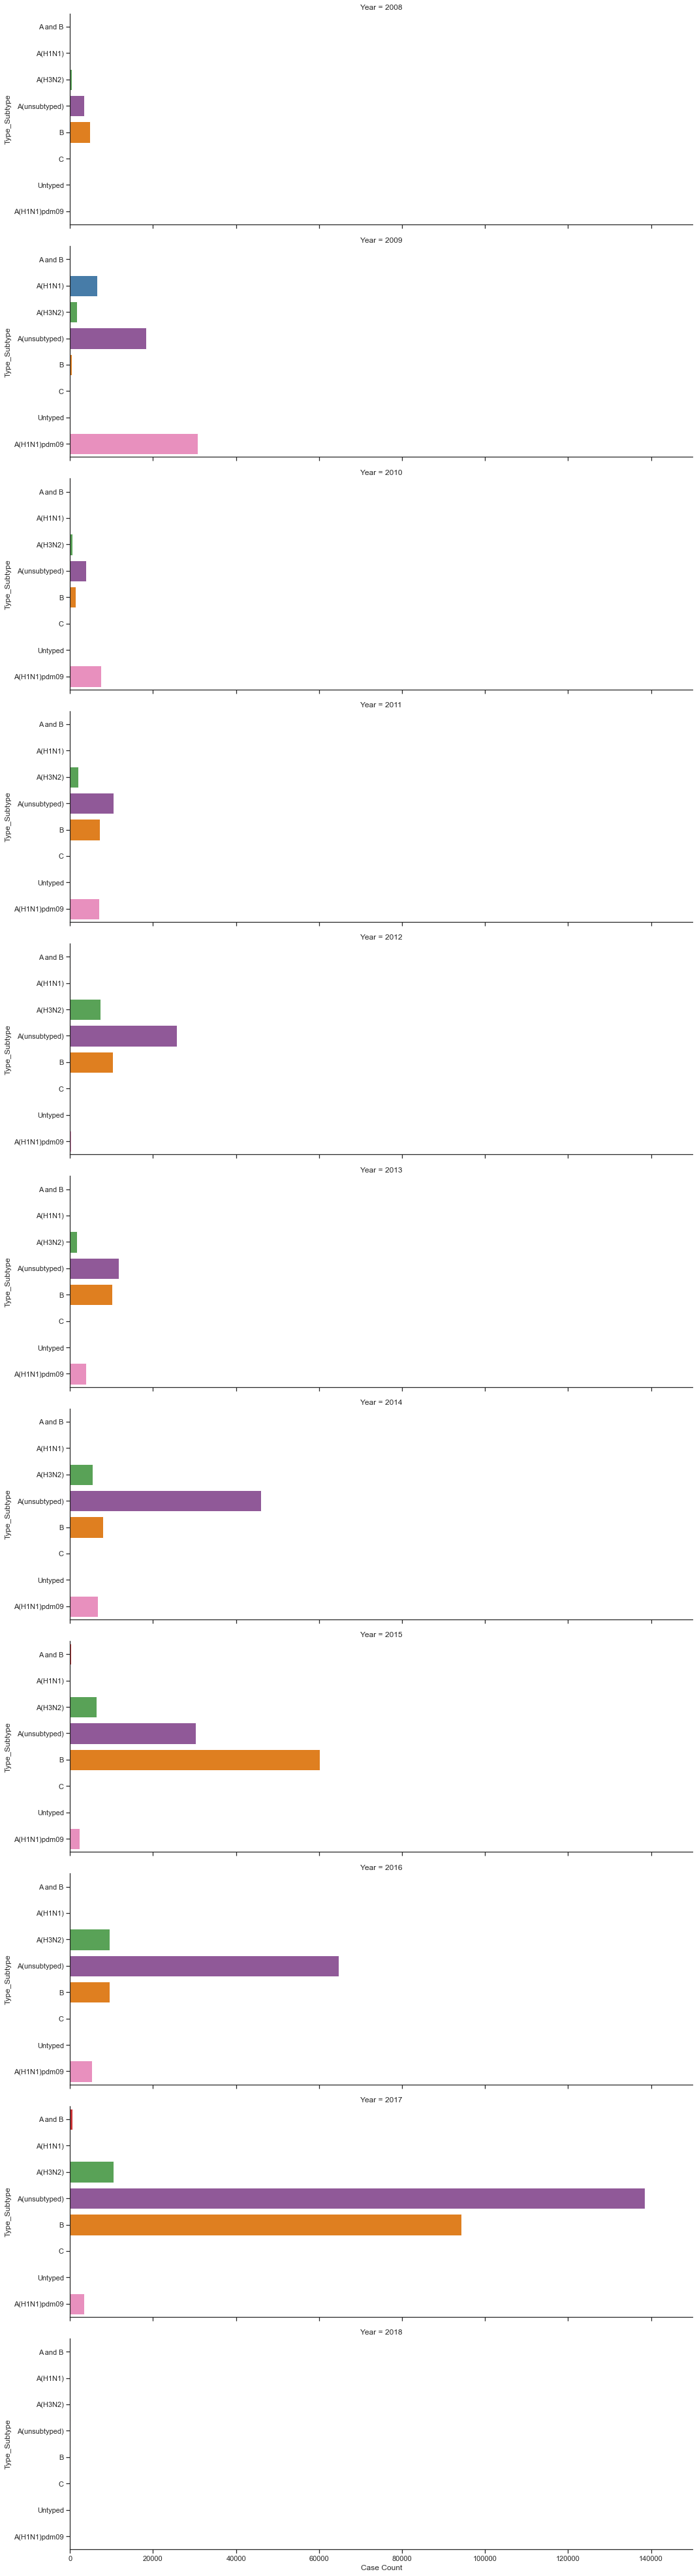

In [41]:
sns_type = sns.catplot(x = 'Case Count', y = 'Type_Subtype', row = 'Year', data = data_type, kind = 'bar', height = 5, \
                      aspect = 3, palette = 'Set1')
sns_type.set(xlim = (0, 150000))
plt.show()

**Insight** : The flu **A(unsubtyped)** has been by far the most infectious flu type over the years, except in the year **2015** when **type B** took the cake, **2009** and **2010** when **H1N1** infected the most number of people.

Now, let's do something similar with states as well.

In [42]:
data_type = data[['State', 'Type_Subtype']]

In [43]:
data_type = ps.sqldf('select State, Type_Subtype, count(Type_Subtype) as [Case Count] from data_type \
group by State, Type_Subtype')

In [44]:
data_type.head()

,State,Type_Subtype,Case Count
0,NSW,A and B,877
1,NSW,A(H1N1),1672
2,NSW,A(H1N1)pdm09,16328
3,NSW,A(H3N2),19389
4,NSW,A(unsubtyped),114058


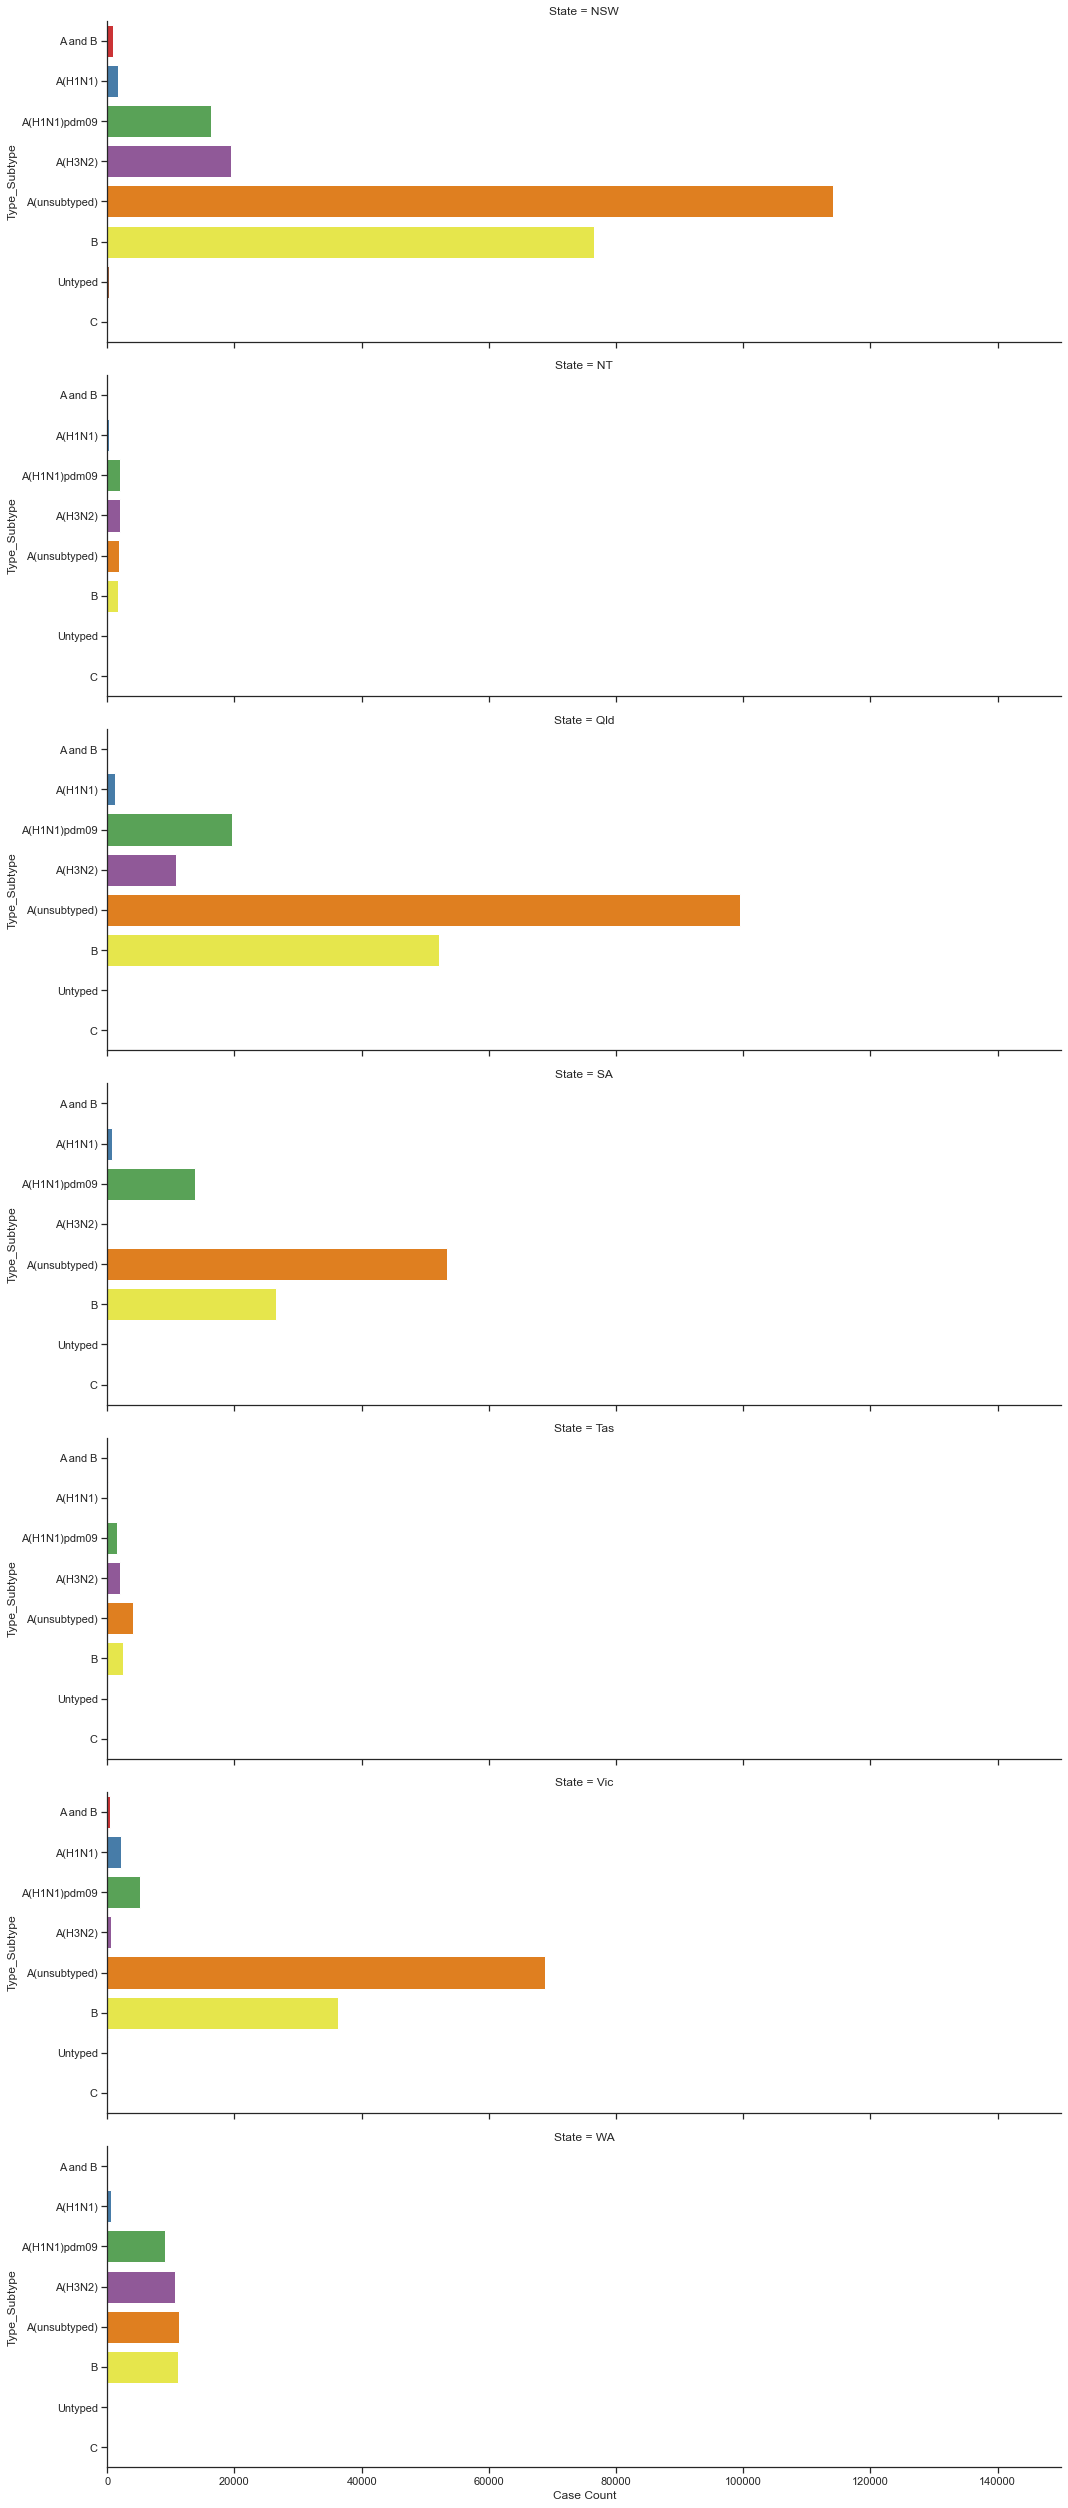

In [45]:
sns_type = sns.catplot(x = 'Case Count', y = 'Type_Subtype', row = 'State', data = data_type, kind = 'bar', height = 5, \
                      aspect = 3, palette = 'Set1')
sns_type.set(xlim = (0, 150000))
plt.show()

**Insight** : If you look at the data state wise, **A(unsubtyped)** turns out to be the most infectious flu of all with **NSW** reporting the highest number of cases. 

### Does the Flu affect Female and Male differently?

I think a better question would be to ask if females catch the flu more easily than males, given the proportion of female cases as compared to males. Let's first see the general trend over the years. 

In [46]:
data_gender.head()

,Year,Sex,Case Count
0,2008,Female,4634
1,2008,Male,4264
2,2008,Unknown,8
3,2009,Female,29172
4,2009,Male,28248


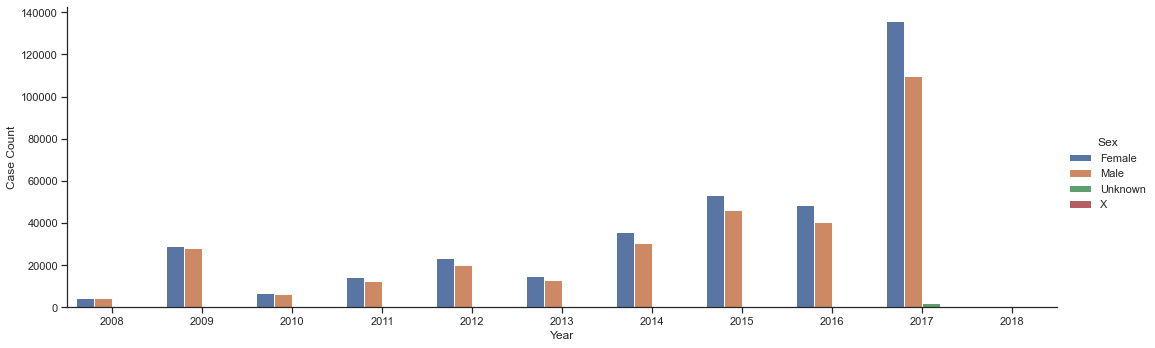

In [47]:
sns.catplot(x = 'Year', y = 'Case Count', hue = 'Sex', kind = 'bar', height = 5, aspect = 3, data = data_gender)

**Insight** : On average, **Females catch the flu more than any other gender**.

# Hypothesis Testing

Hypothesis testing is a statistical method that is used in making statistical decisions using experimental data. Hypothesis Testing is basically an assumption that we make about the population parameter. Hypothesis testing is an essential procedure in statistics. A hypothesis test evaluates two mutually exclusive statements about a population to determine which statement is best supported by the sample data. When we say that a finding is statistically significant, it’s thanks to a hypothesis test.

- **Null hypothesis** : In inferential statistics, the null hypothesis is a general statement or default position that there is no relationship between two measured phenomena, or no association among groups. <br>

- **Alternative hypothesis** : It's the hypothesis used in hypothesis testing that is contrary to the null hypothesis. It is usually taken to be that the observations are the result of a real effect (with some amount of chance variation superposed)<br>

source - https://towardsdatascience.com/hypothesis-testing-in-machine-learning-using-python-a0dc89e169ce

In [48]:
data_hypothesis = data[['Date', 'Sex']]

In [49]:
data_hypothesis = ps.sqldf('select Date, Sex, count(Sex) as [Case Count] from data_hypothesis group by \
Date, Sex')

In [50]:
data_hypothesis.head()

,Date,Sex,Case Count
0,2008-01-04 00:00:00.000000,Female,6
1,2008-01-04 00:00:00.000000,Male,8
2,2008-01-11 00:00:00.000000,Female,11
3,2008-01-11 00:00:00.000000,Male,12
4,2008-01-18 00:00:00.000000,Female,12


Let's isualize the distribution of the female and male cases.

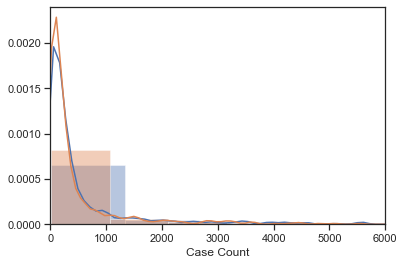

In [51]:
sns_hypothesis = sns.distplot(data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Female'], bins = 10)
sns_hypothesis = sns.distplot(data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Male'], bins = 10)

sns_hypothesis.set(xlim = (0, 6000))
plt.show()

There's not a world of difference between the two distributions. But we will know for sure only through a statistical test. We could do a **test for distribution** (whether male and females belong to the same population) and a **test for mean** (whether there is a statistically significant difference in their mean cases.

In [52]:
female_avg = data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Female'].mean()
male_avg = data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Male'].mean()

print('Difference in Female and Male case count mean is: ' + str(female_avg - male_avg))

Difference in Female and Male case count mean is: 105.19311663479925


We're going to be doing a lot of **permutation** and **bootstrapping** we will have to do in order to generate more and more samples for hypothesis testing.

In [53]:
def permutation_sample(data1, data2):

    data = np.concatenate((data1, data2))

    permuted_data = np.random.permutation(data)

    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

`permutation_sample` function takes in two datasets, combines them and performs random permutation to get random data points. We can now start converting our data points into numpy arrays, so we can optimize the computation.

In [54]:
female_original = np.array(data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Female'])
male_original = np.array(data_hypothesis['Case Count'][data_hypothesis['Sex'] == 'Male'])

In [55]:
def draw_perm_reps(data_1, data_2, func, size = 1):

    perm_replicates = np.empty(size)

    for i in range(size):
        
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

`draw_perm_reps` is the function declared above which when given two separate data arrays, creates permanent replicates of the input data.

In [56]:
def diff_of_means(data_1, data_2):

    diff = np.mean(data_1) - np.mean(data_2)

    return diff

`diff_of_means` is a function which just finds the mean difference between two numpy arrays. In this case, we will use it to calculate the difference between female and male permuted arrays.

We will now generate 10000 permuted samples with the original female and male population sample which we have and test for a difference in their distribution. We can evaluate the p-value to either accept or reject the null hypothesis.

- **Null Hypothesis**: Female and Male case distributions are identical.

- **Alternate Hypothesis** : Female and Male case distributions are fundamentally different.

In [57]:
np.random.seed(137)

empirical_diff_means = diff_of_means(female_original, male_original)

perm_replicates = draw_perm_reps(female_original, male_original,
                                 diff_of_means, size = 10000)

p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)
print('p-value =', p)

p-value = 0.1292


The p-value tells you that there is about a 12.92% chance that you would get the difference of means observed in the experiment if people were exactly the same (not males and females). A p-value below 0.01 is typically said to be "statistically significant". However, as it turns out, our hypothesis has proved out to work in favor of the alternate hypothesis.

Now, we want to test for the difference in means. And this is how we will define the hypotheis fot this problem.

- **Null Hypothesis**: Female and Male case means are identical.

- **Alternate Hypothesis** : Female and Male case means are different.

In [58]:
def bootstrap_replicate_1d(data, func):
    
    bs_sample = np.random.choice(data, len(data))
    
    return func(bs_sample)

`bootstrap_replicate_1d` function generates random values of datapoints, given an input array. For example, we can send the male distribution array as an input and get another, bootstrapped male cases distribution dataset.

In [59]:
def draw_bs_reps(data, func, size = 1):

    bs_replicates = np.empty(size)

    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)

    return bs_replicates

Very similar to `draw_perm_reps`, `draw_bs_reps` also generates random datapoints. The only difference here is that we will send female and male case distributions separately, instead of a concatenated dataset as our goal is to **test for proportion of means**.

In [60]:
data_cases = data.groupby('Date').count()
data_cases = data_cases['State']
data_cases = pd.DataFrame(data_cases)
data_cases.columns = ['Case Count']

data_cases.head()

,Case Count
Date,
2008-01-04,14
2008-01-11,23
2008-01-18,31
2008-01-25,26
2008-02-01,15


In [61]:
mean_case = np.mean(data_cases)

print('Mean case count for the entire dataset is: ' + str(mean_case))

Mean case count for the entire dataset is: Case Count    1302.586998
dtype: float64


In [62]:
case_female_shifted = female_original - np.mean(female_original) + int(mean_case)
case_male_shifted = male_original - np.mean(male_original) + int(mean_case)

Above, we have created the shifted means, caliberated by the mean number of cases in the dataset.

In [63]:
bs_replicates_females = draw_bs_reps(case_female_shifted, np.mean, 10000)
bs_replicates_males = draw_bs_reps(case_male_shifted, np.mean, 10000)

We've now generated 10000 samples, having similar distributions to the female and male populatoin distribution.

In [64]:
bs_replicates = bs_replicates_females - bs_replicates_males

In [65]:
p = np.sum(bs_replicates >= empirical_diff_means) / len(bs_replicates)

print('p-value =', p)

p-value = 0.1223


The result is the same as before! The p-value of 0.1223 suggests that female and male mean cases are indeed identical. **Therefore, I can confidently say that flu does not affect females and males differently**.

### State, Sex, Indigenous Status, Age drive Flu?

In machine learning and statistics, feature selection, also known as variable selection, attribute selection or variable subset selection, is the process of selecting a subset of relevant features for use in model construction. Therefore, if we were to build a regression forecast model for our cases, we will only use a handful of the variables at play here. (source - https://en.wikipedia.org/wiki/Feature_selection)

But which variables? Let's get all of them in one place and fit a model and plot the feature importance.

In [66]:
data_driver = ps.sqldf('select State, Age_Group, Sex, Indigenous_Status, Type_Subtype, count(Sex) as [Case Count] from data \
group by State, Age_Group, Sex, Indigenous_Status, Type_Subtype')

We will make use of the ready-made `XGBRegressor` to train and fit the model and the `plot_importance` method from the xgboost class to visualize our top features in the dataset.

In [67]:
from xgboost import XGBRegressor
from xgboost import plot_importance

Since the data is all categorical, we are required to convert the data into **one-hot encodings** before the xgboost model is able to perform regression. By nature, xgboost requires the user to pass the data as numbers. To perform this, we will make use of the `get_dummies` method from the pandas library.

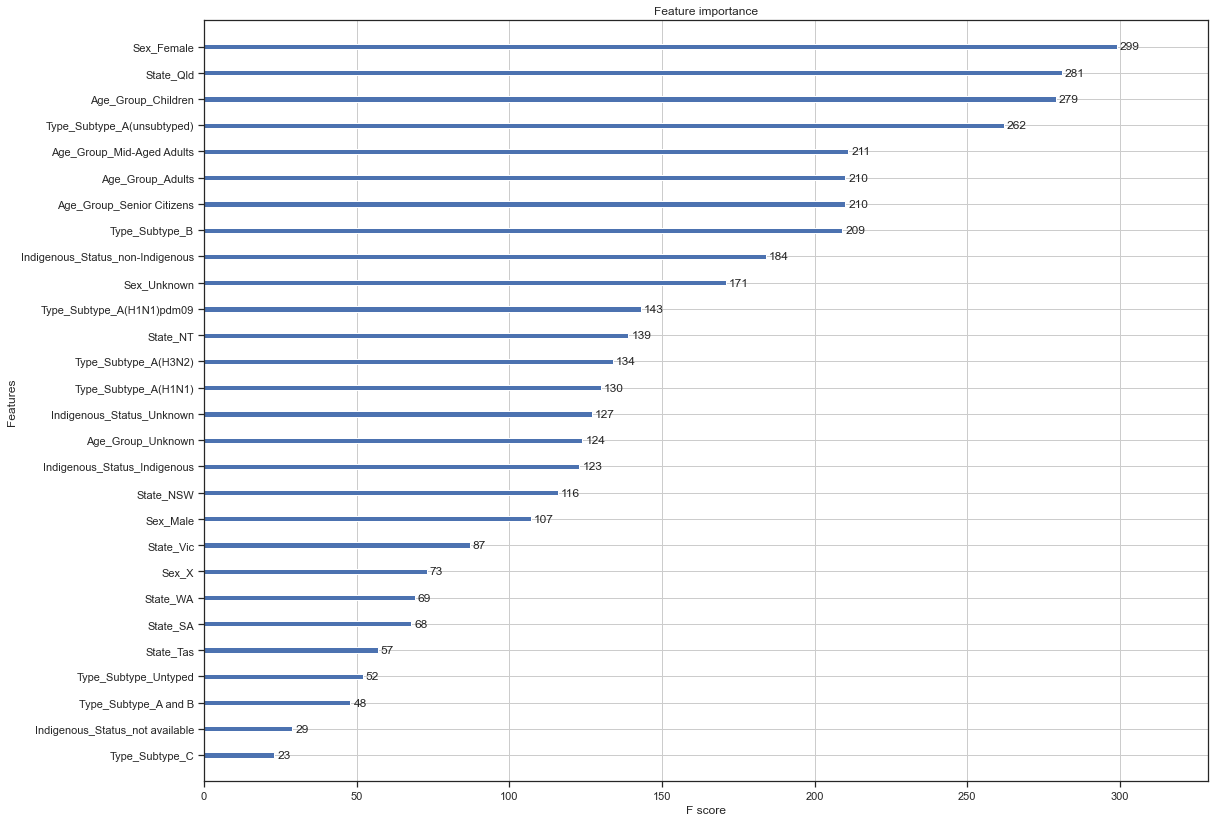

In [68]:
X = data_driver[['State', 'Age_Group', 'Sex', 'Indigenous_Status', 'Type_Subtype']]
y = data_driver['Case Count']

X = pd.get_dummies(X)

model = XGBRegressor()
model.fit(X, y)

ax = plot_importance(model)
fig = ax.figure
fig.set_size_inches(18, 14)

**Insight** : Clearly, some of the variables stand out like `Sex_Female`, `State_Qld`, `Age_Group_Children` and `Type_Subtype_A(unsubtyped)` are some of the most important features. On an overall basis, **Sex, Age and Type** drive the flu cases the most.

# Time Series Analysis and Visualization

We have now come to the most exciting part of this case study where we'll forecast the number of flu cases for the next 6 months. Let us begin by plotting the time-series.

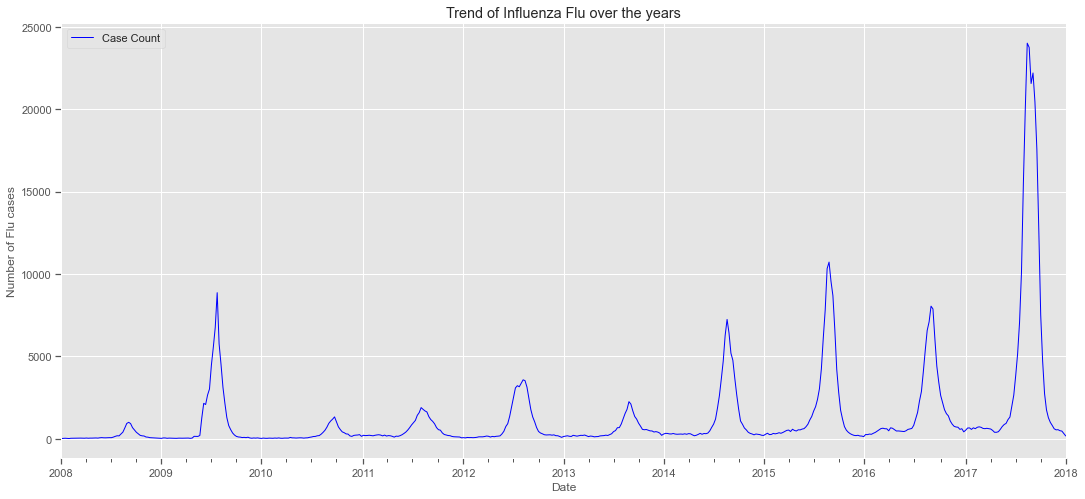

In [69]:
plt.style.use('ggplot')
ax = data_cases.plot(color = 'blue', linewidth = 1, figsize = (18, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Number of Flu cases')
ax.set_title('Trend of Influenza Flu over the years')
plt.show()

There are certainly some distinct peaks, some more prominent than others. It also looks like that the flu is seasonal? This could also be inferred from the first plot we made for the number of cases with the month.

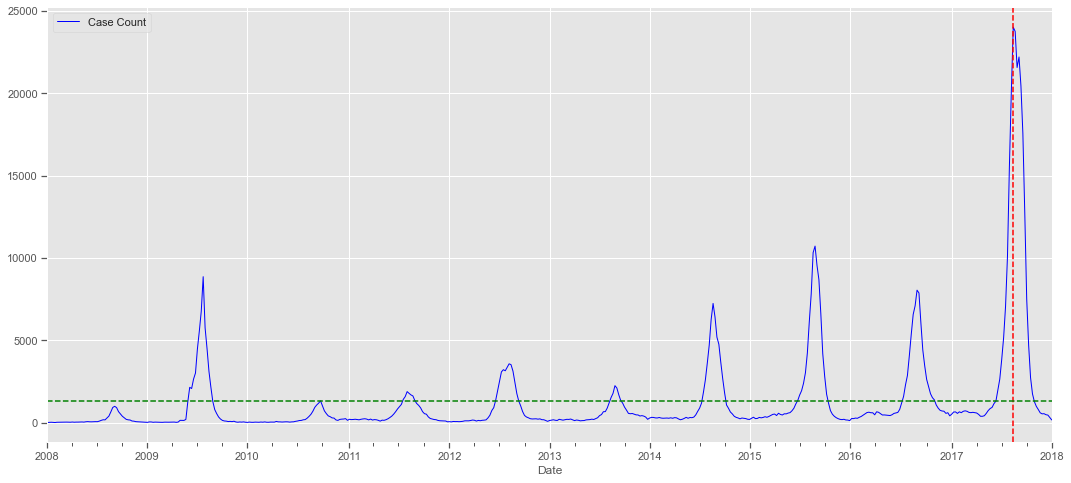

In [70]:
data_2017_2018 = data_cases['2008':'2018']
ax = data_2017_2018.plot(color = 'blue', linewidth = 1, figsize = (18, 8))
ax.axvline('2017-08-15', color = 'red', linestyle = '--')
overall_avg = data_cases.mean()[0]
ax.axhline(overall_avg, color = 'green', linestyle = '--')
plt.show()

The national average of 1300 something falls pale in comparison with the peaks represented in the graph, further consolidating our belief that there could be a strong seasonal pattern in this time-series. 

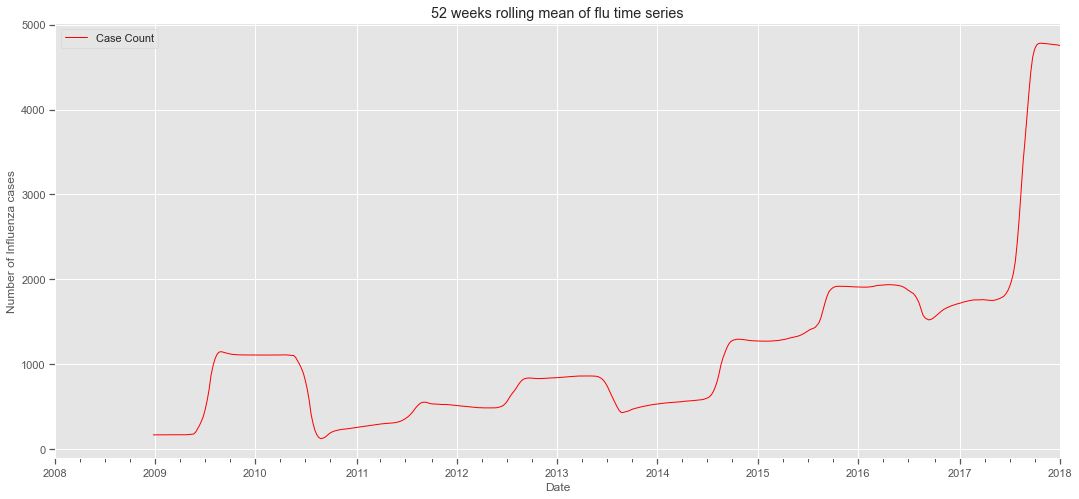

In [71]:
data_moving = data_cases.rolling(window = 52).mean()
ax = data_moving.plot(color = 'red', linewidth = 1, figsize = (18, 8))
ax.set_xlabel('Date')
ax.set_ylabel('Number of Influenza cases')
ax.set_title('52 weeks rolling mean of flu time series')
plt.show()

Plotting a 52-week rolling window mean, it exposes an upward trend in the time-series, suggesting that the flu has either mutated to become stronger or more and more people are not following basic hygeine. 

# Summary Statistics

In [72]:
data_cases.head()

,Case Count
Date,
2008-01-04,14
2008-01-11,23
2008-01-18,31
2008-01-25,26
2008-02-01,15


In [73]:
data_cases.describe()

,Case Count
count,523.000000
mean,1302.586998
std,3016.787086
min,14.000000
25%,147.500000
50%,328.000000
75%,917.500000
max,24004.000000


In [74]:
from statsmodels.graphics import tsaplots
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

### Autocorrelation

Autocorrelation, also known as serial correlation, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations as a function of the time lag between them. The analysis of autocorrelation is a mathematical tool for finding repeating patterns, such as the presence of a periodic signal obscured by noise, or identifying the missing fundamental frequency in a signal implied by its harmonic frequencies. It is often used in signal processing for analyzing functions or series of values, such as time domain signals. (source - https://en.wikipedia.org/wiki/Autocorrelation)

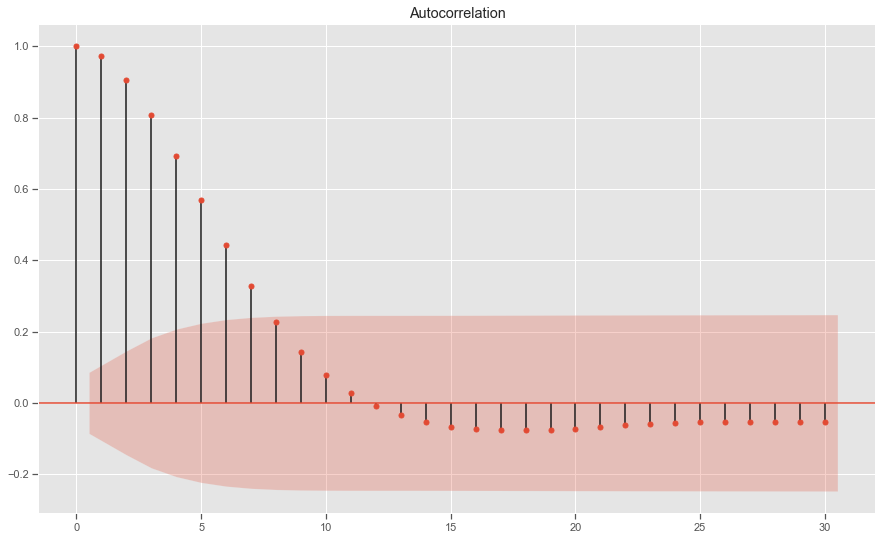

In [75]:
rcParams['figure.figsize'] = 15, 9
fig = tsaplots.plot_acf(data_cases['Case Count'], lags = 30)
plt.show()

### Partial Autocorrelation

The partial autocorrelation function (PACF) gives the partial correlation of a stationary time series with its own lagged values, regressed the values of the time series at all shorter lags. It contrasts with the autocorrelation function, which does not control for other lags. (source - https://en.wikipedia.org/wiki/Partial_autocorrelation_function)

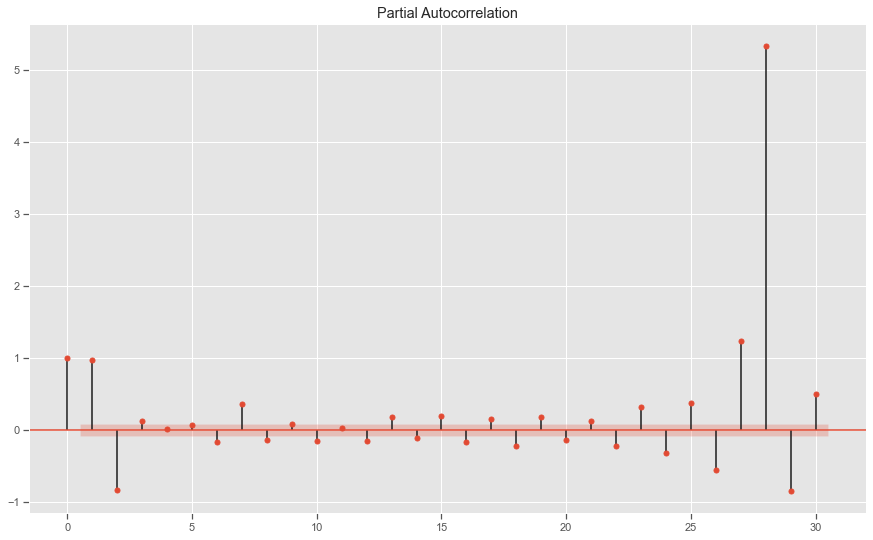

In [76]:
rcParams['figure.figsize'] = 15, 9
fig = tsaplots.plot_pacf(data_cases['Case Count'], lags = 30)
plt.show()

### Seasonality, Trend and Noise

It's of paramount importance for us to figure out if our data is seasonal, has a trend or if there is a white noise function that comes embedded into our data. Knowing these important features of a time-series data, we can more accurately forecast and hence build a better model.

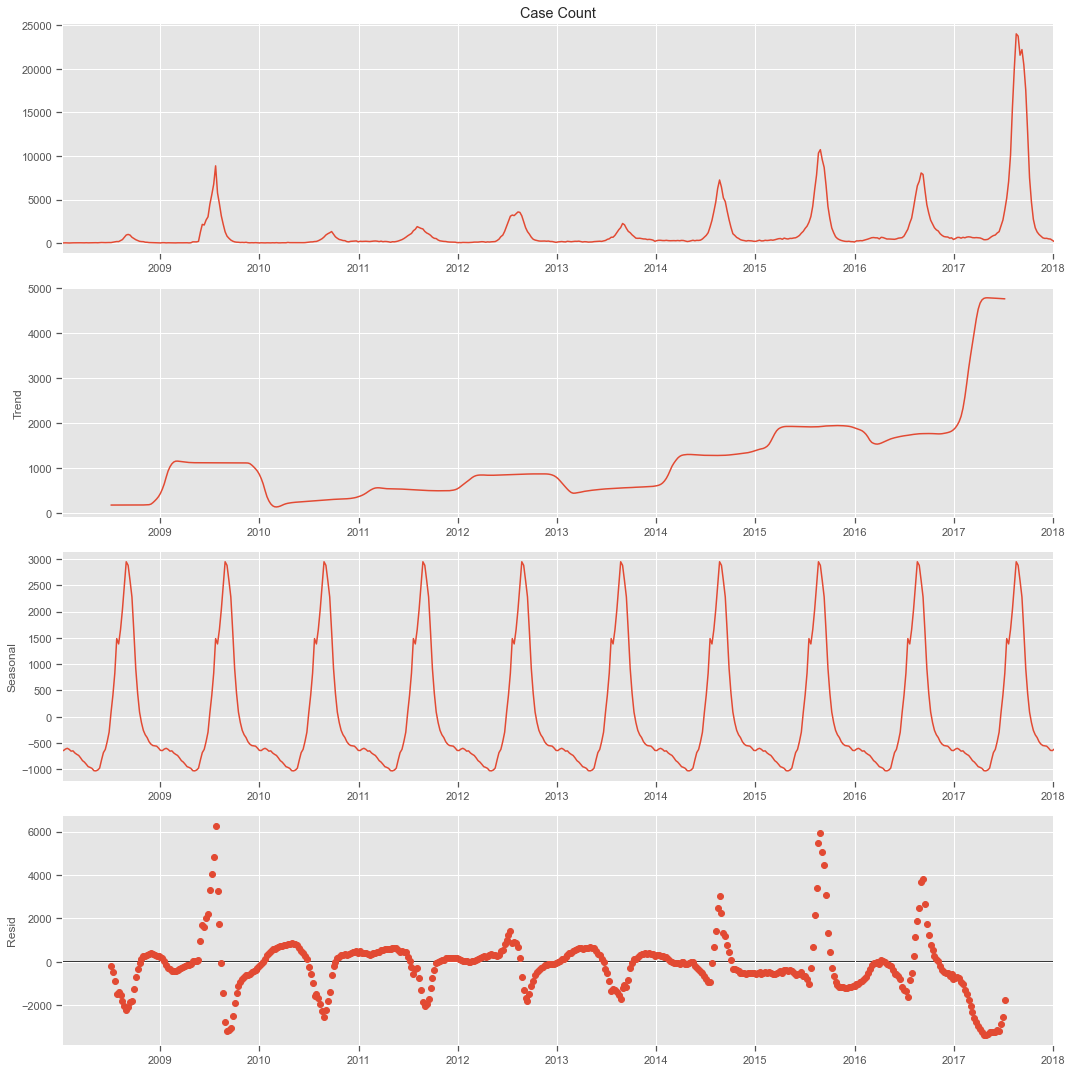

In [77]:
rcParams['figure.figsize'] = 15, 15
decomposition = sm.tsa.seasonal_decompose(data_cases['Case Count'])
fig = decomposition.plot()
plt.show()

There's some evidence that the data is seasonal and has an upward trend. 

## Dicky-Fuller test for testing Stationarity

**Null Hypothesis** : Time-series is non-stationary<br>
**Alternate Hypothesis** : Time-series is stationary

In [78]:
stationarity = adfuller(data_cases['Case Count'])

In [79]:
print('Test statistic for stationarity is: ' + str(stationarity[0]))

Test statistic for stationarity is: -5.127929867825583


Generally, the more negative the test statistic is, the more is the probability of the time-series being stationary.<br>
Let's check for the p-value. If the p-value is less than 0.05, then we reject the null hypothesis.

In [80]:
print('The p-value for our time-series is: ' + str(stationarity[1]))
stationarity[1] < 0.05

The p-value for our time-series is: 1.2314997351946584e-05


True

Therefore, we can confidently say that out time-series is stationary.

# SARIMAX Modelling (In-sample Forecast)

## ARMA

In statistics and econometrics, and in particular in time series analysis, an autoregressive integrated moving average (ARIMA) model is a generalization of an autoregressive moving average (ARMA) model. Both of these models are fitted to time series data either to better understand the data or to predict future points in the series (forecasting). ARIMA models are applied in some cases where data show evidence of non-stationarity, where an initial differencing step (corresponding to the "integrated" part of the model) can be applied one or more times to eliminate the non-stationarity.

The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values. The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past. The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). The purpose of each of these features is to make the model fit the data as well as possible.

Non-seasonal ARIMA models are generally denoted ARIMA(p,d,q) where parameters p, d, and q are non-negative integers, p is the order (number of time lags) of the autoregressive model, d is the degree of differencing (the number of times the data have had past values subtracted), and q is the order of the moving-average model. Seasonal ARIMA models are usually denoted ARIMA(p,d,q)(P,D,Q)m, where m refers to the number of periods in each season, and the uppercase P,D,Q refer to the autoregressive, differencing, and moving average terms for the seasonal part of the ARIMA model. (source - https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average)

SARMAX - Seasonal Autoregressive Integrated Moving Average Exogenous model

In [81]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

We will now define a very basic, non-seasonal ARMA(1, 1) model with 0 differencing and fit it to our data and predict on the last 6 months of the data. This is knows as an  in-sampling prediction or one-step ahead forecasting.

In [82]:
model = SARIMAX(data_cases['Case Count'], order = (1, 0, 1)) # Same as ARMA (1, 1)

In [83]:
results = model.fit()

Calculating the forecasts and their confidence intervals so that we can later visualize them to get a better sense of our forecasts.

In [84]:
forecast = results.get_prediction(start = -26) # In-sample prediction
mean_forecast = forecast.predicted_mean
confidence_int = forecast.conf_int()

lower_limits = confidence_int.loc[:,'lower Case Count']
upper_limits = confidence_int.loc[:,'upper Case Count']

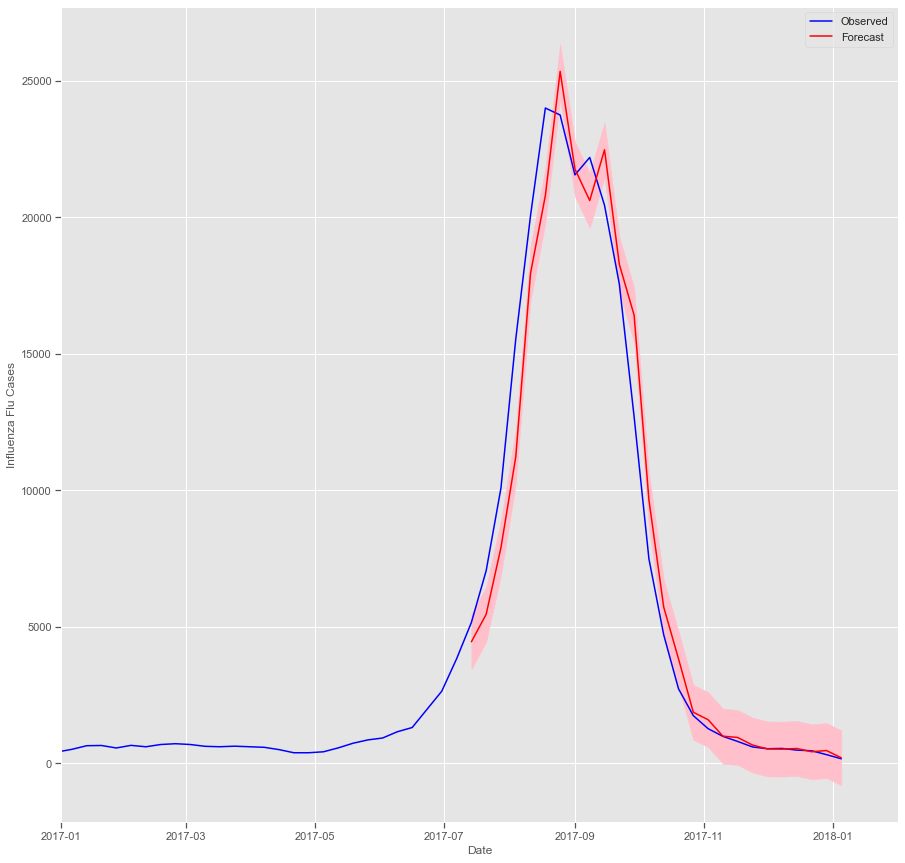

In [85]:
plt.figure()

plt.plot(data_cases.index, data_cases, color = 'blue', label = 'Observed')
plt.plot(mean_forecast.index, mean_forecast, color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.xlabel('Date')
plt.ylabel('Influenza Flu Cases')
plt.xlim('2017', '2018-02')
plt.legend()
plt.show()

Great forecast, but considering that this prediction can easily be mapped by taking a single lag difference from our original time-series is a bit disappointing. 

# Identifying the correct model order

In [86]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

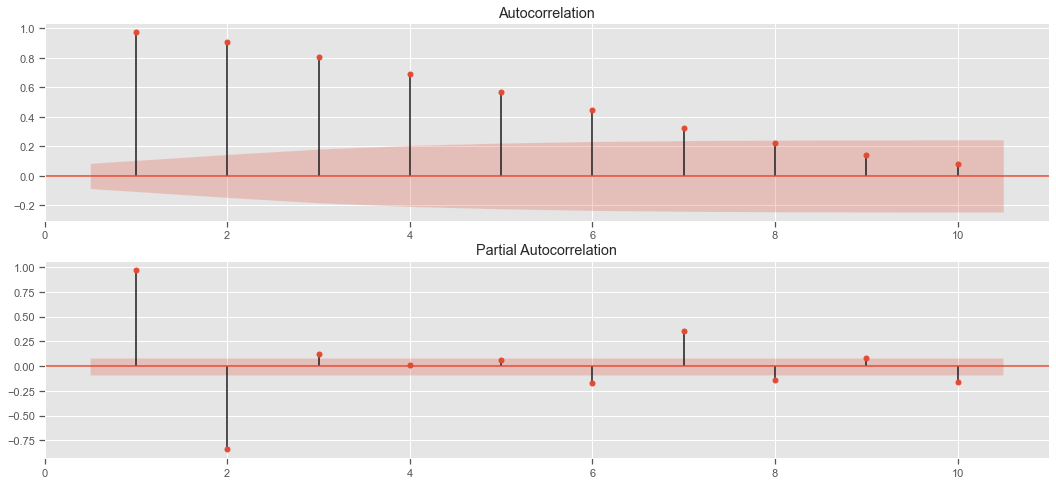

In [87]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (18, 8))

plot_acf(data_cases, lags = 10, zero= False, ax = ax1) # Setting zero to false to hide ACF at lag 0 as it'll be always 1
plot_pacf(data_cases, lags = 10, zero= False, ax = ax2)

plt.show()

The ACF cuts-off after 7 lags and PACF tails-off, suggesting that this could be a ARMA(2, 2) model. But can we find the best model for sure?

# ARIMA or ARMA?

We've already established that our time-series is stationary with the help of Dicky-Fuller test. So the question is, do we still difference our time-series or do we use it as is? Only way to find that out is to experiment with the best hyperparameters and use them on both ARMA and ARIMA.

# ARIMA (p, 1, q)

Here, we will find the best p and q values for our ARIMA model with series differencing set to 1.

In [88]:
order_aic_bic = []
for p in range(5):
    for q in range(5):
        model = SARIMAX(data_cases, order = (p, 1, q), trend = 'c')
        results = model.fit()
        order_aic_bic.append((p, q, results.aic, results.bic))

In [89]:
order_aic_bic = pd.DataFrame(order_aic_bic, columns = ['p', 'q', 'AIC', 'BIC'])

In [90]:
print(order_aic_bic.sort_values('AIC').head())

    p  q          AIC          BIC
24  4  4  7798.981941  7841.558617
23  4  3  7803.074117  7841.393125
19  3  4  7807.290702  7845.609710
18  3  3  7809.222982  7843.284323
16  3  1  7812.716713  7838.262719


In [91]:
print(order_aic_bic.sort_values('BIC').head())

    p  q          AIC          BIC
16  3  1  7812.716713  7838.262719
12  2  2  7812.728280  7838.274286
23  4  3  7803.074117  7841.393125
24  4  4  7798.981941  7841.558617
18  3  3  7809.222982  7843.284323


# ARMA (p, 0, q)

Here, we will find the best p and q parameters for our ARMA model with differencing set to 0.

In [92]:
order_aic_bic = []
for p in range(5):
    for q in range(5):
        model = SARIMAX(data_cases, order = (p, 0, q), trend = 'c')
        results = model.fit()
        order_aic_bic.append((p, q, results.aic, results.bic))

In [93]:
order_aic_bic = pd.DataFrame(order_aic_bic, columns = ['p', 'q', 'AIC', 'BIC'])

In [94]:
print(order_aic_bic.sort_values('AIC').head())

    p  q          AIC          BIC
24  4  4  7820.373407  7862.969222
23  4  3  7821.332271  7859.668504
19  3  4  7821.930223  7860.266456
22  4  2  7825.820900  7859.897552
18  3  3  7827.580301  7861.656953


In [95]:
print(order_aic_bic.sort_values('BIC').head())

    p  q          AIC          BIC
10  2  0  7830.133190  7847.171516
11  2  1  7832.054901  7853.352808
15  3  0  7832.056625  7853.354533
16  3  1  7828.884099  7854.441588
21  4  1  7828.935496  7858.752566


AIC vs BIC:<br>

- BIC favors simpler model than AIC
- AIC is better at choosing predictive models
- BIC is better at choosing good explanatory models

Comparing the model performance while keeping AIC and BIC values, we can confirm that an ARIMA model with the order (4,1,4) would be the best model, since our goal is to make a good predictive model.

# Optimized ARIMA Model

Now, we know that our best model has the order (4, 1, 4) and now we can reproduce what we did earlier, but with different orders.

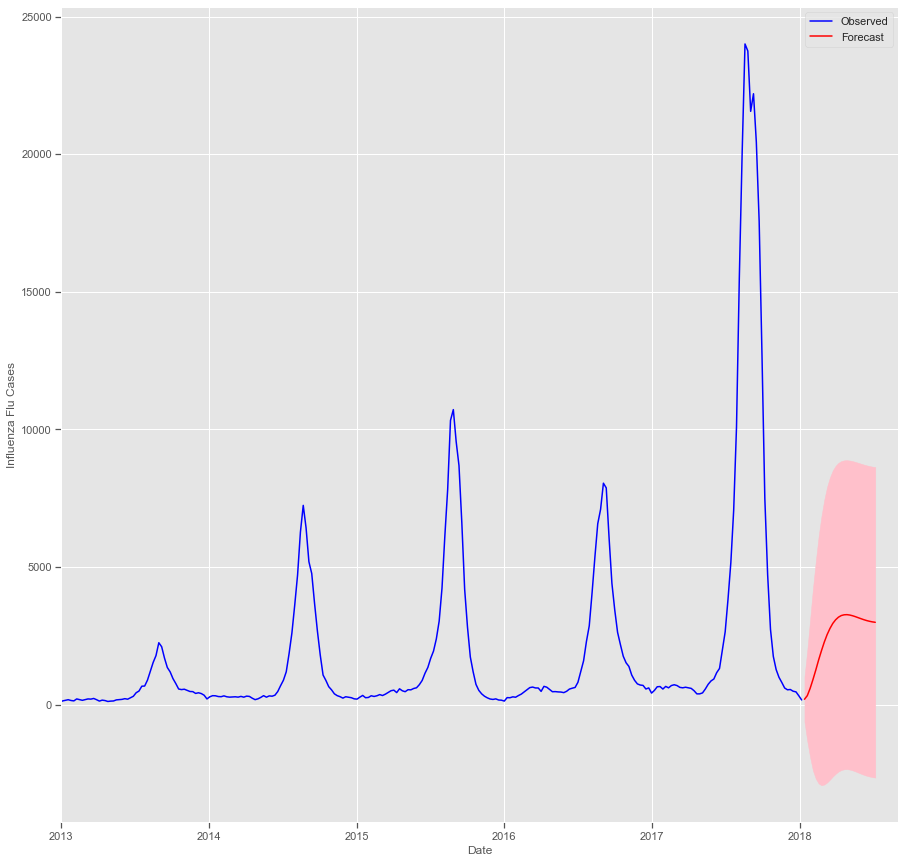

In [96]:
model = SARIMAX(data_cases, order = (4, 1, 4), trend = 'c')
arima_results = model.fit()
arima_value_forecast = arima_results.get_forecast(steps = 26).predicted_mean

confidence_int = arima_results.get_forecast(steps = 26).conf_int()
lower_limits = confidence_int.loc[:,'lower Case Count']
upper_limits = confidence_int.loc[:,'upper Case Count']

plt.figure()

plt.plot(data_cases.index, data_cases, color = 'blue', label = 'Observed')
plt.plot(arima_value_forecast.index, arima_value_forecast, color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.xlabel('Date')
plt.ylabel('Influenza Flu Cases')
plt.xlim('2013', '2018-09')
plt.legend()
plt.show()

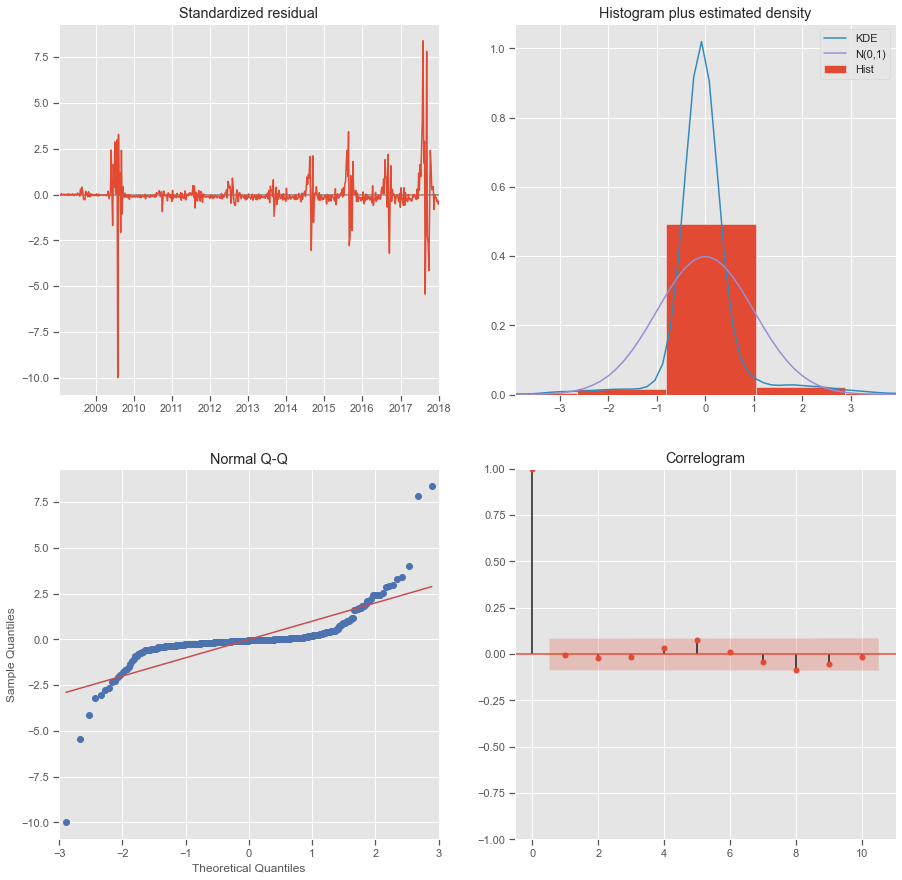

In [97]:
residuals = arima_results.resid
mae = np.mean(np.abs(residuals))

arima_results.plot_diagnostics()
plt.show()

- Standardized Residual : Shows the one step ahead, standardized residuals. There isn't much of a structure in the residuals.
- Histogram + KDE : This plot shows us the distribution of the residuals, we can see that this is not the best model as the lines hardly overlap.
- Normal Q-Q plot : Not all our residuals are normally distributed, giving rise to the Z-shaped structure.
- Correlogram : ACF of the residuals, 95% of the correlations for lag greater than one should not be significant. This seems to be fine here.

In [98]:
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:             Case Count   No. Observations:                  523
Model:               SARIMAX(4, 1, 4)   Log Likelihood               -3889.491
Date:                Mon, 31 Aug 2020   AIC                           7798.982
Time:                        08:56:49   BIC                           7841.559
Sample:                    01-04-2008   HQIC                          7815.658
                         - 01-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.9830      0.768      1.279      0.201      -0.523       2.489
ar.L1          0.4091      0.126      3.236      0.001       0.161       0.657
ar.L2          0.7749      0.124      6.244      0.0

- Prob(Q) (Ljung-Box Test): p-value for null hypothesis that residuals are uncorrelated
- Prob(JB) (Jarque-Bera): p-value for null hypothesis that residuals are normal

# Optimized ARMA Model

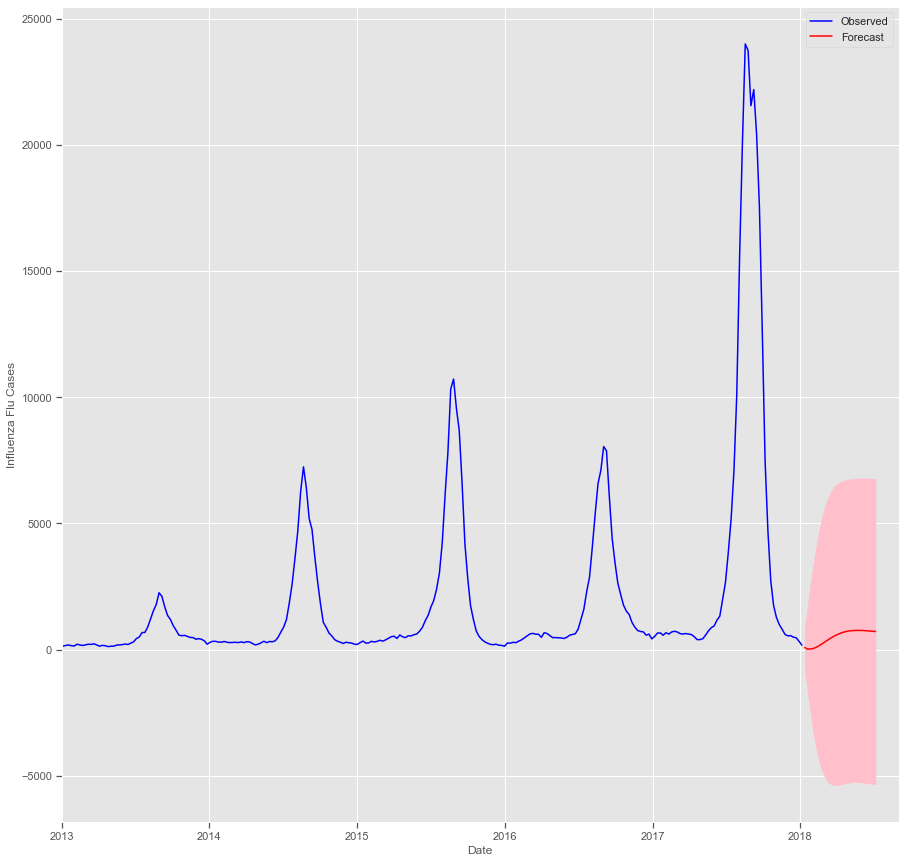

In [99]:
model = SARIMAX(data_cases, order = (4, 0, 4), trend = 'c')
arima_results = model.fit()
arima_value_forecast = arima_results.get_forecast(steps = 26).predicted_mean

confidence_int = arima_results.get_forecast(steps = 26).conf_int()
lower_limits = confidence_int.loc[:,'lower Case Count']
upper_limits = confidence_int.loc[:,'upper Case Count']

plt.figure()

plt.plot(data_cases.index, data_cases, color = 'blue', label = 'Observed')
plt.plot(arima_value_forecast.index, arima_value_forecast, color = 'red', label = 'Forecast')

plt.fill_between(lower_limits.index, lower_limits, upper_limits, color = 'pink')
plt.xlabel('Date')
plt.ylabel('Influenza Flu Cases')
plt.xlim('2013', '2018-09')
plt.legend()
plt.show()

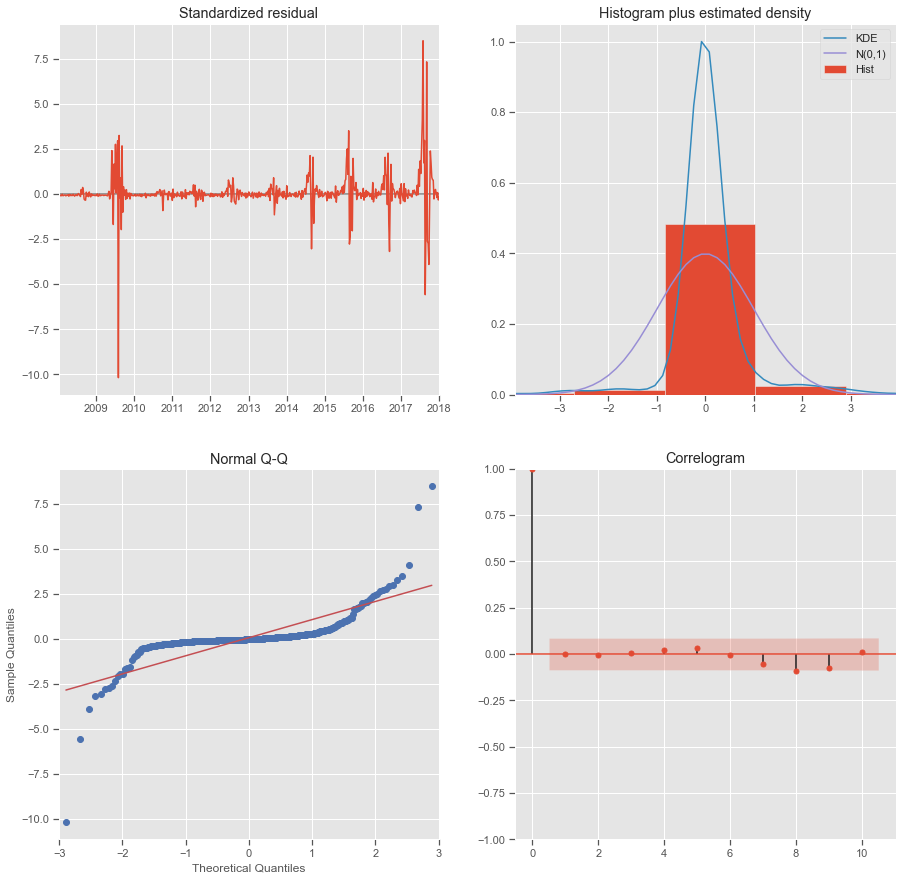

In [100]:
residuals = arima_results.resid
mae = np.mean(np.abs(residuals))

arima_results.plot_diagnostics()
plt.show()

- Standardized Residual : Shows the one step ahead, standardized residuals. There isn't much of a structure in the residuals.
- Histogram + KDE : This plot shows us the distribution of the residuals, we can see that this is not the best model as the lines hardly overlap.
- Normal Q-Q plot : Not all our residuals are normally distributed, giving rise to the Z-shaped structure.
- Correlogram : ACF of the residuals, 95% of the correlations for lag greater than one should not be significant. This seems to be fine here.

In [101]:
print(arima_results.summary())

                               SARIMAX Results                                
Dep. Variable:             Case Count   No. Observations:                  523
Model:               SARIMAX(4, 0, 4)   Log Likelihood               -3900.187
Date:                Mon, 31 Aug 2020   AIC                           7820.373
Time:                        08:56:52   BIC                           7862.969
Sample:                    01-04-2008   HQIC                          7837.056
                         - 01-05-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     73.2302     97.884      0.748      0.454    -118.618     265.078
ar.L1          0.7078      0.224      3.157      0.002       0.268       1.147
ar.L2          0.5270      0.220      2.396      0.0

- Prob(Q) (Ljung-Box Test): p-value for null hypothesis that residuals are uncorrelated
- Prob(JB) (Jarque-Bera): p-value for null hypothesis that residuals are normal

In [102]:
arima_value_forecast.to_csv('Influenza Flu 6 months Forecast.csv')